# ⛎ End-to-end multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image
classifier using TensorFlow 2.0 and TensorFlow Hub

## 1. Problem
Identifying the breed of the dog given the image of the dog

When I take a photo of the dog and upload it, I want to know what breed it is.

## 2. Data

The data we are using is from Kaggle Dog breed identification competetion

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

Evaluation is a file with prediction probability for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Some information about data:
* We are dealing with images (unstructured) so its probably best if we use deep/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes)
* There are around 10,000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set (these images have no lables because we will want to predict them)


In [ ]:
# Run this only once and then comment, just in case you dont accidently run this everytime.
# !unzip "/content/drive/MyDrive/AI Project/dog-breed-identification.zip" -d "/content/drive/MyDrive/AI Project/"

### Get our workspace ready

In [ ]:
import tensorflow as tf

In [ ]:
print ("TensorFlow version : " + tf.__version__)

TensorFlow version : 2.19.0


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.19.0
Hub version: 0.16.1
GPU not available :(


# Adding a GPU to TensorFlow
By default Colab runs on a computer located on Google's servers which doesn't have a GPU attached to it.
But we can fix this going to runtime and then changing the runtime type:

Go to Runtime.
Click "Change runtime type".
Where it says "Hardware accelerator", choose "GPU" (don't worry about TPU for now but feel free to research them).
Click save.
The runtime will be restarted to activate the new hardware, so you'll have to rerun the above cells.
If the steps have worked you should see a print out saying "GPU available".

# Getting data ready
Since much of machine learning is getting your data ready to be used with a machine learning model, we'll take extra care getting it setup.

There are a few ways we could do this. Many of them are detailed in the Google Colab notebook on I/O (input and output).

And because the data we're using is hosted on Kaggle, we could even use the Kaggle API.

This is great but what if the data you want to use wasn't on Kaggle?

One method is to upload it to your Google Drive, mount your drive in this notebook and import the file.

In [ ]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/AI Project/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<Axes: xlabel='breed'>

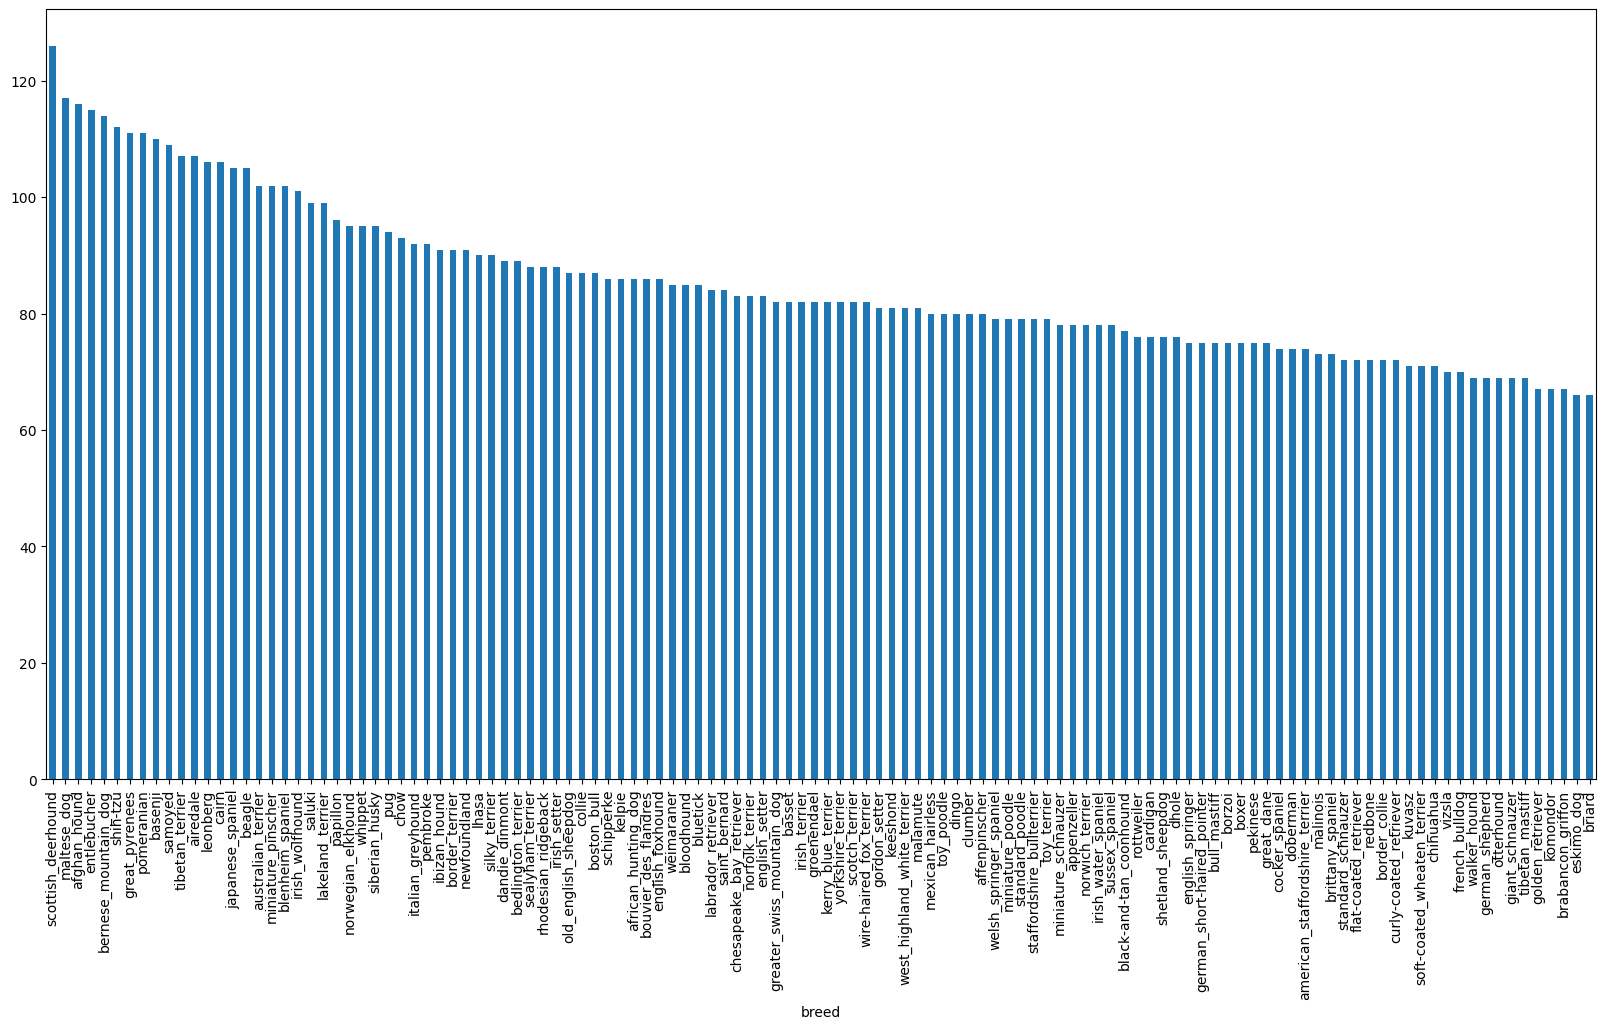

In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
komondor                 67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

In [ ]:
labels_csv["breed"]

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [ ]:
# Calculate mean
print(labels_csv["breed"].value_counts().mean())
# Calculate median
print(labels_csv["breed"].value_counts().median())

85.18333333333334
82.0


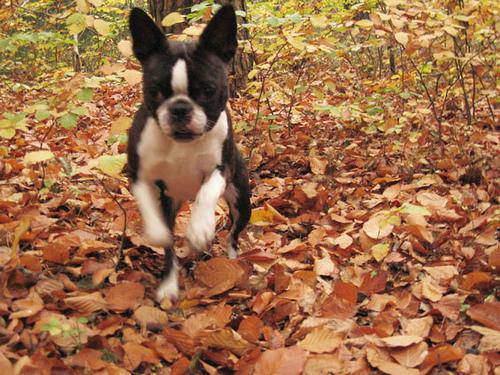

In [ ]:
# Let's check out one of the images.
from IPython.display import display, Image
Image("/content/drive/MyDrive/AI Project/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

# Getting images and their labels
Since we've got the image ID's and their labels in a DataFrame (labels_csv), we'll use it to create:

* A list a filepaths to training images
* An array of all labels
* An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

In [ ]:
# Create pathnames from image ID's
filenames = ["/content/drive/MyDrive/AI Project/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
filenames[:10]


['/content/drive/MyDrive/AI Project/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/AI Project/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/AI Project/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/AI Project/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/AI Project/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/AI Project/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/AI Project/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/AI Project/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/AI Project/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/AI Project/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

Now we've got a list of all the filenames from the ID column of labels_csv, we can compare it to the number of files in our training data directory to see if they line up.

If they do, great. If not, there may have been an issue when unzipping the data (what we did above), to fix this, you might have to unzip the data again. Be careful not to let your Colab notebook disconnect whilst unzipping.

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("/content/drive/MyDrive/AI Project/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


Visualizing directly from a filepath.

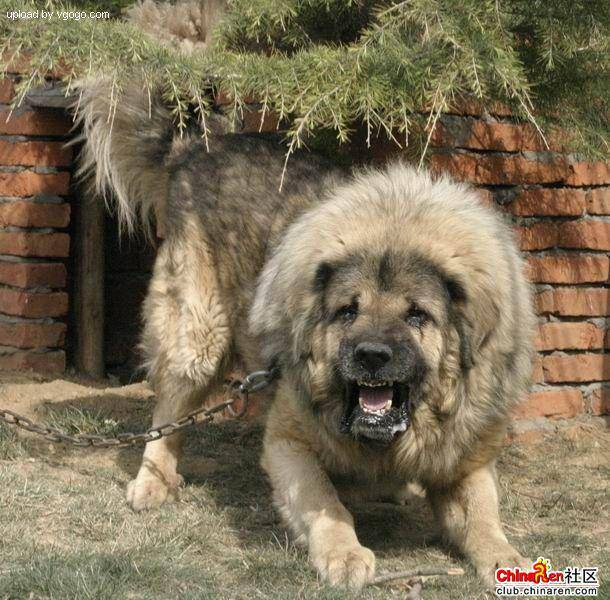

In [ ]:
# Check an image directly from a filepath
Image(filenames[9000])

# Convert labels into numbers

In [ ]:
# We'll take them from labels_csv and turn them into a NumPy array.
import numpy as np
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")


Number of labels matches number of filenames!


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)


120

In [ ]:
# Example: Turn one label into an array of booleans
print(labels[0])
labels[0] == unique_breeds # use comparison operator to create boolean array

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Example: Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
filenames[:10]

['/content/drive/MyDrive/AI Project/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/AI Project/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/AI Project/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/AI Project/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/AI Project/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/AI Project/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/AI Project/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/AI Project/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/AI Project/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/AI Project/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

## Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set (a split of the data we can test our model on before making final predicitons on the test set), let's make one.

We could use Scikit-Learn's train_test_split function or we could simply make manual splits of the data.

For accessibility later, let's save our filenames variable to X (data) and our labels to y.

In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

Since we're working with 10,000+ images, it's a good idea to work with a portion of them to make sure things are working before training on them all.

This is because computing with 10,000+ images could take a fairly long time. And our goal when working through machine learning projects is to reduce the time between experiments.

Let's start experimenting with 1000 and increase it as we need.

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

1000

Now let's split our data into training and validation sets.
We'll use and 80/20 split (80% training data, 20% validation data).

In [ ]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Check out the training data (image file paths and labels)
X_train[:2], y_train[:2]

(['/content/drive/MyDrive/AI Project/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/AI Project/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,

# Preprocessing images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:

* Take an image filepath as input
* Use TensorFlow to read the file and save it to a variable, image
* Turn our image (a jpg) into Tensors
* Normalize our image (convert color channel values from from 0-255 to 0-1).
* Resize the image to be a shape of (224, 224)
* Return the modified image



In [ ]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
image.max(), image.min()

(np.uint8(255), np.uint8(0))

In [ ]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [ ]:
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

We'll create a function to:

* Take an image filepath as input
* Use TensorFlow to read the file and save it to a variable, image
* Turn our image (a jpg) into Tensors
* Normalize our image (convert color channel values from from 0-255 to 0-1).
* Resize the image to be a shape of (224, 224)
* Return the modified image

More information on loading images in TensorFlow can be seen here: https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Normalizing image - Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

# Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: (image, label).

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Demo of the above
process_image(X[42]), tf.constant(y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

# Visualizing Data Batches
Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them!

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

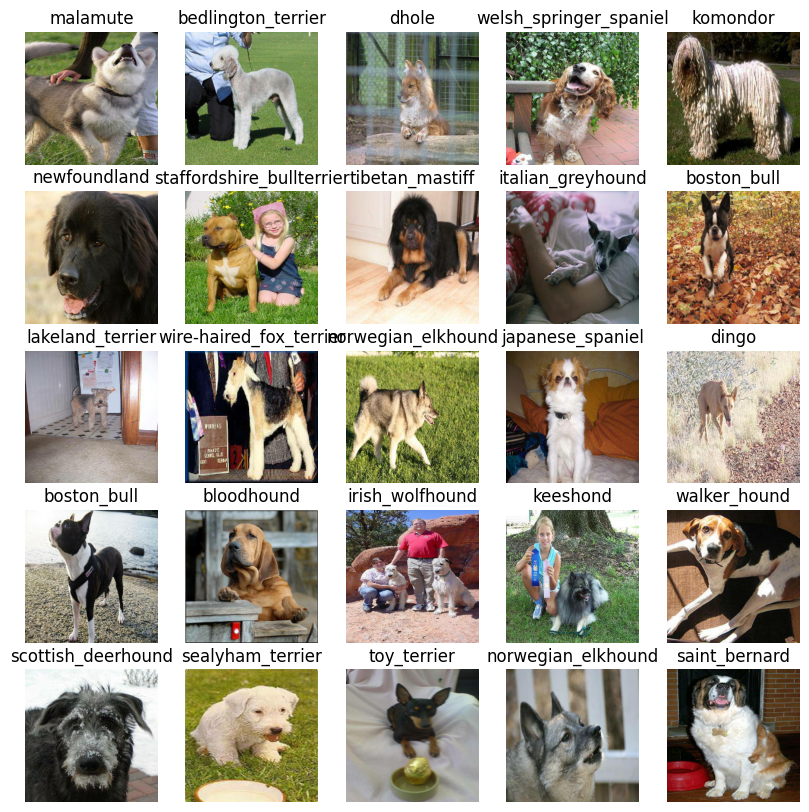

In [ ]:
# # Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

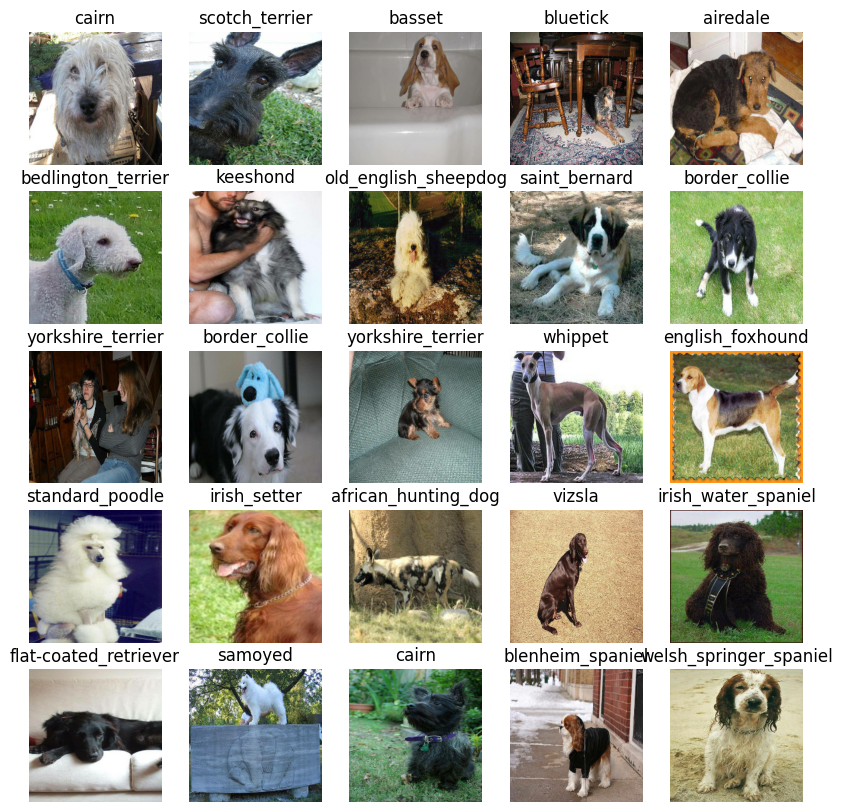

In [ ]:
# # Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

# Building a model
Before we build a model, there are a few things we need to define:

* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [ ]:
IMG_SIZE

224

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub to use a feature vector model
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4"

In [ ]:
INPUT_SHAPE

[None, 224, 224, 3]

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:

* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
  print("Building model using tf.keras.applications.MobileNetV2 for feature extraction")

  # Define the input layer
  inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

  # Load the MobileNetV2 base model from tf.keras.applications
  # (pre-trained on ImageNet, without the top classification layer)
  base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                 include_top=False,
                                                 weights='imagenet')
  base_model.trainable = False # Freeze the base model

  # Connect the base model to the inputs
  x = base_model(inputs)

  # Add a GlobalAveragePooling2D layer to flatten the feature maps
  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  # Add the Dense output layer
  outputs = tf.keras.layers.Dense(units=output_shape, activation="softmax")(x)

  # Create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  return model

In [ ]:
model = create_model()
model.summary()

Building model using tf.keras.applications.MobileNetV2 for feature extraction


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function. ✅
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/AI Project/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Check to make sure we're still running on a GPU
print("GPU", "available (YESSS!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESSS!!!!!!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data - comment below line just for stopping accendential run again
model = train_model()

NameError: name 'create_model' is not defined

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing! It means our model is learning!!!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [ ]:
%tensorboard --logdir "drive/MyDrive/AI Project/logs"

UsageError: Line magic function `%tensorboard` not found.


## Making and evaluating predictions using a trained model

In [ ]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 767ms/step


array([[0.00763603, 0.00669969, 0.02029263, ..., 0.01117639, 0.00335429,
        0.00556308],
       [0.00673173, 0.00425468, 0.00926032, ..., 0.02271752, 0.00775598,
        0.0045344 ],
       [0.00267387, 0.00650314, 0.0030753 , ..., 0.00214718, 0.00563256,
        0.02803826],
       ...,
       [0.00535069, 0.00235226, 0.00518743, ..., 0.0018376 , 0.0066387 ,
        0.01158392],
       [0.00599848, 0.00167541, 0.00853405, ..., 0.00562856, 0.01556445,
        0.01525164],
       [0.00772047, 0.00535837, 0.00682327, ..., 0.00985145, 0.0300811 ,
        0.00338547]], dtype=float32)

In [ ]:
predictions[0]

array([0.00763603, 0.00669969, 0.02029263, 0.03116065, 0.0064869 ,
       0.00528117, 0.00637656, 0.00349447, 0.00541904, 0.01438824,
       0.01663937, 0.0253136 , 0.0055622 , 0.00984475, 0.00489321,
       0.00267558, 0.00795688, 0.00588576, 0.00487895, 0.00627073,
       0.00092994, 0.00669201, 0.00515294, 0.01376571, 0.00531032,
       0.00168164, 0.01587146, 0.00631867, 0.01480648, 0.00824601,
       0.00212062, 0.01911796, 0.00126241, 0.00794077, 0.01125587,
       0.00194913, 0.01017163, 0.00683073, 0.01193105, 0.00797762,
       0.00393149, 0.0167285 , 0.00261871, 0.01062147, 0.03111565,
       0.00337494, 0.0097591 , 0.00555209, 0.00968818, 0.00701649,
       0.01440252, 0.00183506, 0.00528818, 0.04191167, 0.01219136,
       0.01512942, 0.00707136, 0.0053301 , 0.00378761, 0.00507241,
       0.01087392, 0.00482397, 0.00694154, 0.0074711 , 0.0024504 ,
       0.00346101, 0.00295744, 0.00458339, 0.00298283, 0.01271262,
       0.01948835, 0.00329017, 0.03202976, 0.00923176, 0.00370

In [ ]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[0.00263947 0.00319569 0.004544   0.00424566 0.00416756 0.02403459
 0.00183903 0.00492178 0.00626583 0.00479945 0.01752454 0.0092682
 0.0238909  0.00609991 0.00434711 0.00462901 0.00258388 0.00754999
 0.00543671 0.01361282 0.01076792 0.00244042 0.01073474 0.0165427
 0.01304238 0.00332207 0.00515675 0.01247489 0.03280321 0.02232663
 0.00797113 0.00945938 0.00369852 0.00992383 0.00462308 0.00677536
 0.00275654 0.00382897 0.00410455 0.0021302  0.00177267 0.0014065
 0.00726126 0.01096064 0.0142583  0.00839778 0.01022168 0.00312517
 0.00980709 0.02124303 0.00302486 0.00422001 0.00483384 0.00353475
 0.02118653 0.0069801  0.00103081 0.00537896 0.00434872 0.00384554
 0.03262038 0.0034665  0.00802503 0.00662893 0.01102712 0.00262135
 0.00061318 0.00521575 0.00284686 0.01245675 0.0154796  0.0117085
 0.07220528 0.01206199 0.00221899 0.01149356 0.00651643 0.0020857
 0.0082924  0.00475668 0.01316577 0.00306253 0.01068488 0.01711843
 0.00557902 0.00079548 0.00620101 0.01708215 0.01175657 0.00458184


In [ ]:
unique_breeds[113]

'walker_hound'

Having the the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [ ]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'appenzeller'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [ ]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visaulize.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
* Convert the prediction probabilities to a predicted label. ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

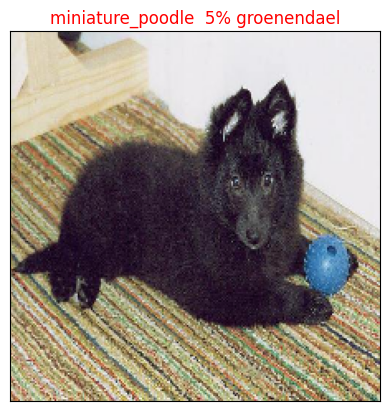

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using `get_pred_label()` ✅
* Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

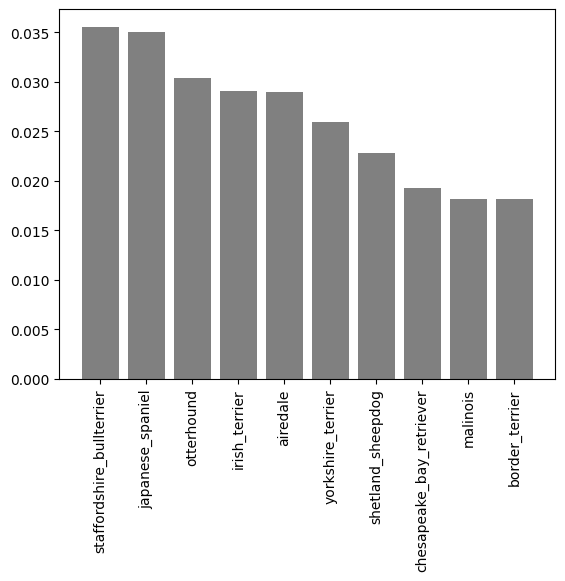

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some function to help us visualize our predictions and evaluate our modle, let's check out a few.

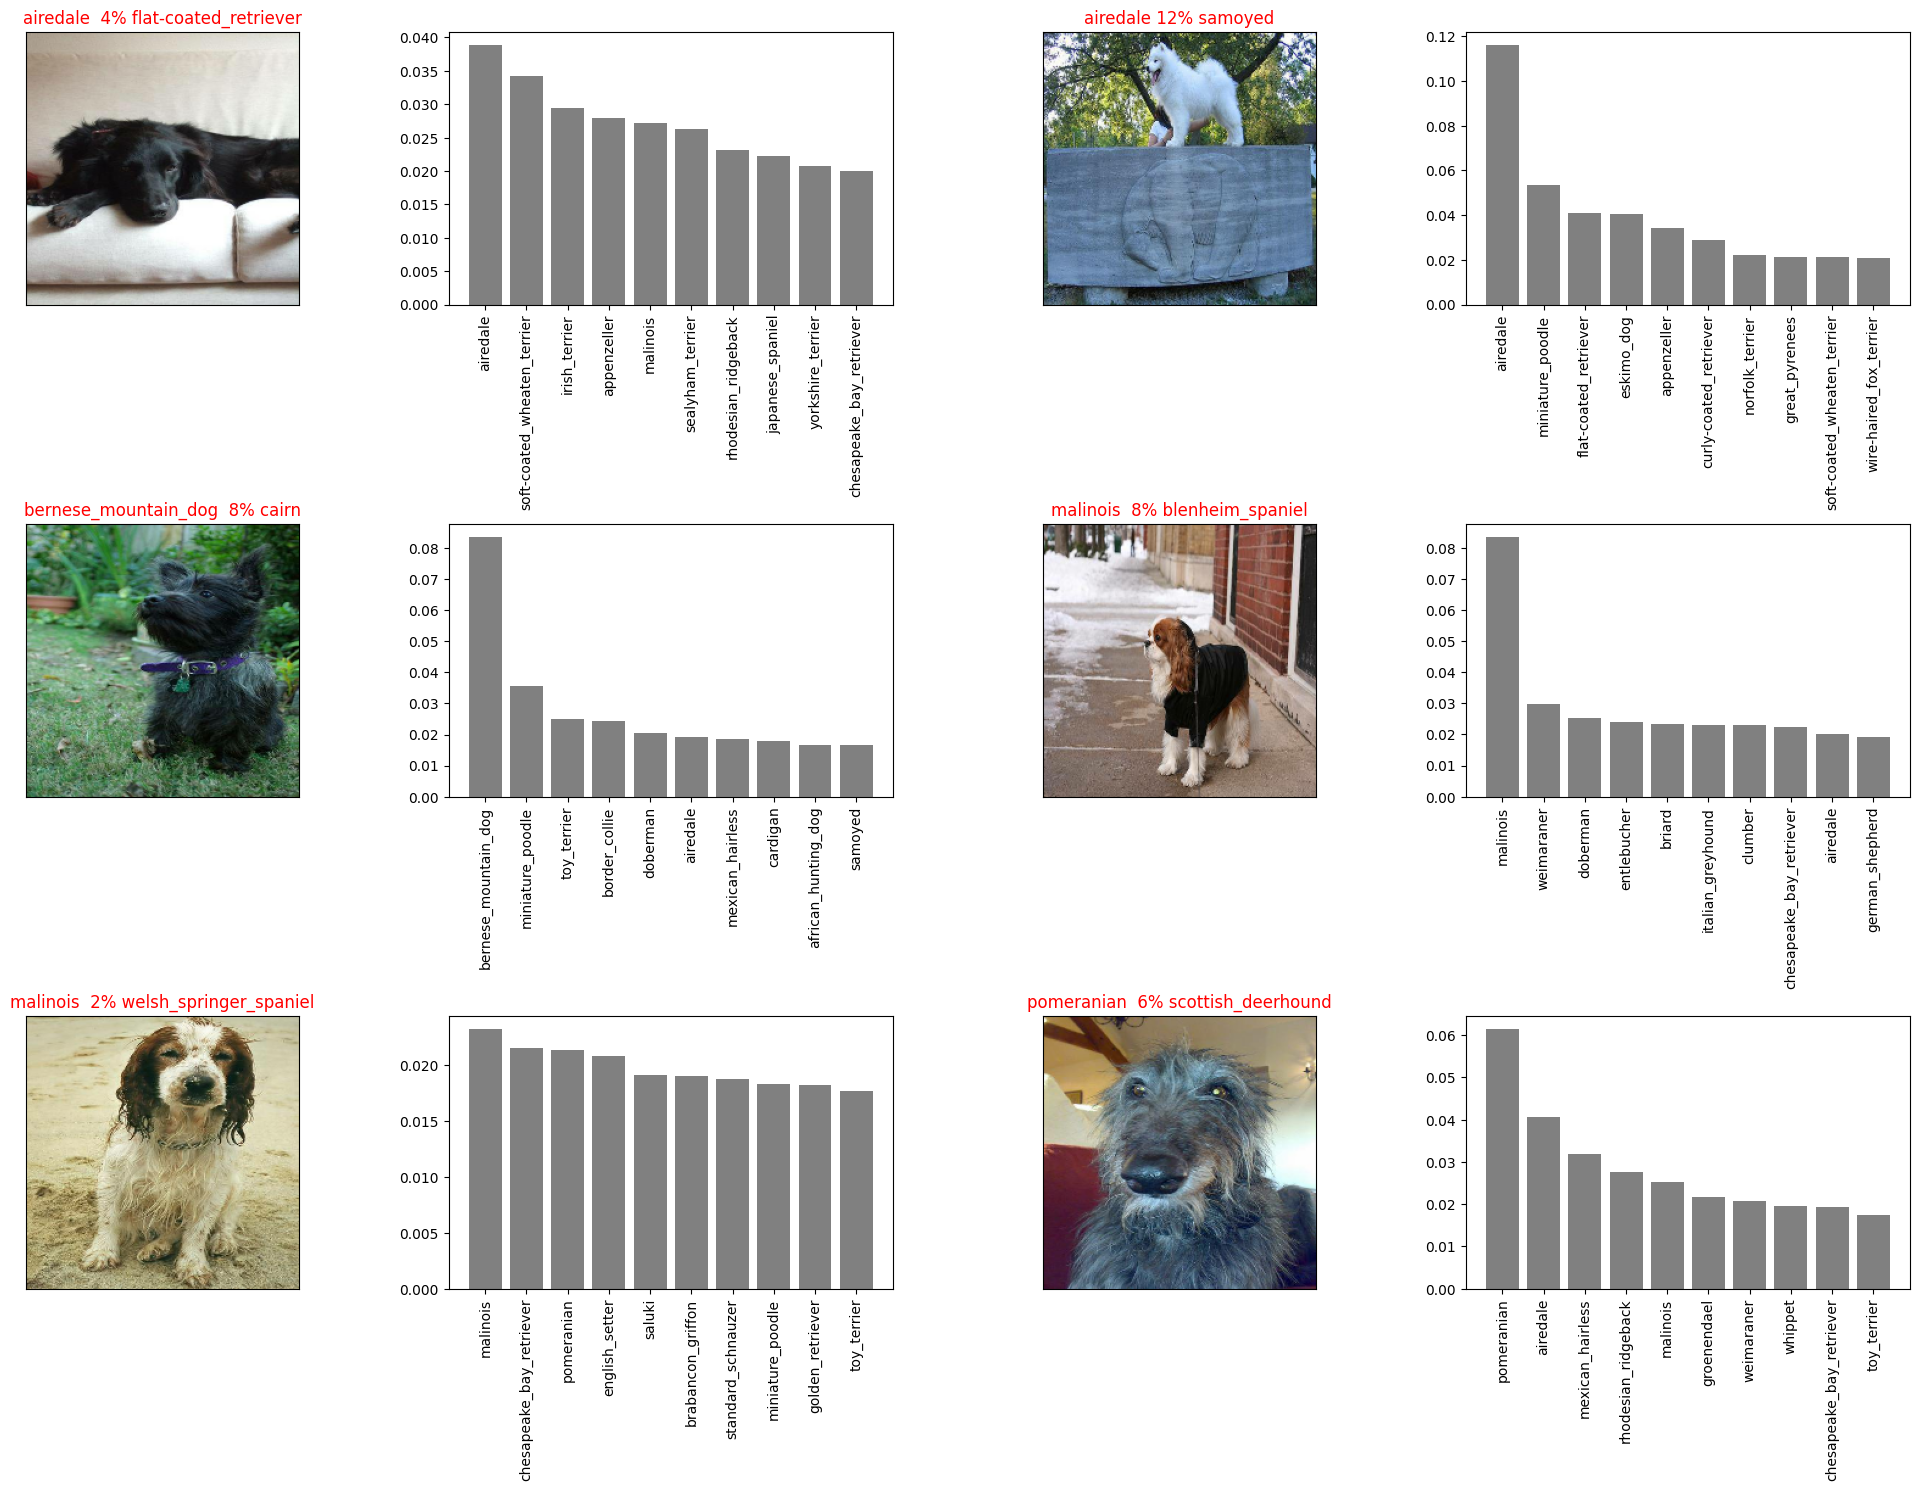

In [ ]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge:** How would you create a confusion matrix with our models predictions and true labels?

## Saving and reloading a trained model

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/AI Project/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/AI Project/models/20260228-17501772301014-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/AI Project/models/20260228-17501772301014-1000-images-mobilenetv2-Adam.h5'

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model('drive/My Drive/AI Project/models/20260228-17501772301014-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/AI Project/models/20260228-17501772301014-1000-images-mobilenetv2-Adam.h5


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 630ms/step - accuracy: 0.0000e+00 - loss: 5.1190


[5.112982273101807, 0.0]

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 801ms/step - accuracy: 0.0000e+00 - loss: 5.1190


[5.112982273101807, 0.0]

## Training a big dog model 🐶 (on the full data)

In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Create a model for full model
full_model = create_model()

Building model using tf.keras.applications.MobileNetV2 for feature extraction


In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while (maybe up to 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 58s 156ms/step - accuracy: 0.4394 - loss: 2.5289
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 45s 141ms/step - accuracy: 0.8333 - loss: 0.5812
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 45s 140ms/step - accuracy: 0.9063 - loss: 0.3590
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 82s 140ms/step - accuracy: 0.9476 - loss: 0.2415
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - accuracy: 0.9722 - loss: 0.1659
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 45s 140ms/step - accuracy: 0.9818 - loss: 0.1329
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 82s 139ms/step - accuracy: 0.9903 - loss: 0.1019
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 45s 141ms/step - accuracy: 0.9927 - loss: 0.0788
Epoch 9/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 45s 141ms/step - accuracy: 0.9968 - loss: 0.0622
Epoch 10/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 45s 141ms/step - accuracy: 0.9980 - loss: 0.0490
Epoch 11/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 45s 142ms/step - accuracy: 0.9984 - loss: 0.0402
Epoch 12

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/AI Project/models/20260228-18091772302152-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/AI Project/models/20260228-18091772302152-full-image-set-mobilenetv2-Adam.h5'

In [ ]:
# Load in the full model
loaded_full_model = load_model('drive/My Drive/AI Project/models/20260228-18091772302152-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/My Drive/AI Project/models/20260228-18091772302152-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and conver them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames. ✅
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels). ✅
* Make a predictions array by passing the test batches to the `predict()` method called on our model.

In [ ]:
# Load test image filenames
test_path = "/content/drive/MyDrive/AI Project/test"
test_filenames = [os.path.join(test_path, fname) for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/MyDrive/AI Project/test/e26901a9e04f0ba89765fb9b9b7f675f.jpg',
 '/content/drive/MyDrive/AI Project/test/e51de127ddf2c492372a63f0644b1a58.jpg',
 '/content/drive/MyDrive/AI Project/test/e09f4ff3f7acee994812650a2fc7edef.jpg',
 '/content/drive/MyDrive/AI Project/test/e3982348ad8b974cef2298f741bc3c99.jpg',
 '/content/drive/MyDrive/AI Project/test/e7f95aabf775a636b3893ffa120adaf9.jpg',
 '/content/drive/MyDrive/AI Project/test/e01a1ea716359e2f0062aca591ff9ca4.jpg',
 '/content/drive/MyDrive/AI Project/test/e64d56f012476f124591a22648114a37.jpg',
 '/content/drive/MyDrive/AI Project/test/e6af47e8b6973c8f8d2b9fd5af94c54d.jpg',
 '/content/drive/MyDrive/AI Project/test/e2c7aeef019a6577f3988a84be2b5769.jpg',
 '/content/drive/MyDrive/AI Project/test/e265af5e8f446888c6e7ec31f803d63e.jpg']

In [ ]:
len(test_filenames)

10357

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about a ~1hr). This is because we have to process ~10,000+ images and get our model to find patterns in those images and generate predictions based on what its learned in the training dataset.

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 ━━━━━━━━━━━━━━━━━━━━ 142s 424ms/step


In [ ]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("drive/My Drive/AI Project/preds_array.csv", test_predictions, delimiter=",")

In [ ]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("drive/My Drive/AI Project/preds_array.csv", delimiter=",")

In [ ]:
test_predictions[:10]

array([[2.03627559e-10, 7.94342925e-11, 1.05112430e-09, ...,
        9.99505401e-01, 1.60295986e-05, 4.95601338e-09],
       [1.64196024e-07, 8.35570813e-09, 8.55175841e-08, ...,
        7.52771972e-03, 8.59951979e-06, 9.96514871e-08],
       [5.11872391e-13, 5.99049009e-14, 5.11315541e-08, ...,
        3.36537376e-08, 2.30485325e-10, 7.79047937e-11],
       ...,
       [1.37046868e-07, 4.77254236e-09, 5.64099301e-09, ...,
        3.77907305e-09, 1.66275015e-11, 8.94283092e-10],
       [2.10108264e-10, 7.03544056e-10, 9.16730780e-09, ...,
        5.24556162e-06, 2.66563632e-07, 1.63460086e-07],
       [4.89658341e-08, 6.32126830e-05, 3.27771872e-08, ...,
        4.77523536e-05, 7.94331427e-05, 6.07262862e-08]])

In [ ]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probaiblity outputs in a DataFrame with an ID and a column for each different dog breed.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed. ✅
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilites) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [ ]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [ ]:
preds_df.head()

id affenpinscher afghan_hound  \
0  e26901a9e04f0ba89765fb9b9b7f675f           NaN          NaN   
1  e51de127ddf2c492372a63f0644b1a58           NaN          NaN   
2  e09f4ff3f7acee994812650a2fc7edef           NaN          NaN   
3  e3982348ad8b974cef2298f741bc3c99           NaN          NaN   
4  e7f95aabf775a636b3893ffa120adaf9           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  e26901a9e04f0ba89765fb9b9b7f675f   2.036276e-10  7.943429e-11   
1  e51de127ddf2c492372a63f0644b1a58   1.641960e-07  8.355708e-09   
2  e09f4ff3f7acee994812650a2fc7edef   5.118724e-13  5.990490e-14   
3  e3982348ad8b974cef2298f741bc3c99   1.795192e-08  6.182815e-12   
4  e7f95aabf775a636b3893ffa120adaf9   8.855152e-01  7.662835e-09   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         1.051124e-09  9.890200e-09                    6.276120e-06   
1         8.551758e-08  6.185749e-08                    2.228163e-03   
2         5.113155e-08  9.360941e-11                    4.811049e-06   
3         9.655961e-08  2.249276e-11                    6.389073e-09   
4         5.507653e-08  8.390014e-09                    3.748291e-09   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  5.360205e-11        7.671139e-08  1.861968e-05  4.848244e-07  ...   
1  1.935602e-06        2.900387e-11  1.222591e-06  5.264032e-09  ...   
2  9.842395e-08        2.574298e-13  4.531325e-09  4.865827e-09  ...   
3  6.788898e-07        2.352965e-09  2.905485e-06  4.688364e-09  ...   
4  4.202910e-09        1.204830e-08  8.987944e-09  3.933934e-09  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  1.187774e-10  2.928530e-11  9.208197e-11  2.722165e-08  6.600167e-09   
1  5.130000e-10  1.481886e-05  2.206834e-04  3.716552e-06  1.338873e-01   
2  9.559201e-14  1.758784e-06  3.802985e-09  2.733710e-10  4.238551e-08   
3  9.315962e-07  4.188996e-06  4.179808e-09  7.142524e-05  1.245611e-06   
4  2.780081e-04  2.063760e-07  1.601120e-08  9.048154e-11  8.702281e-09   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            2.766764e-08                 1.022053e-05  9.995054e-01   
1            4.616089e-09                 8.602025e-09  7.527720e-03   
2            2.837036e-10                 3.559705e-12  3.365374e-08   
3            1.689807e-09                 1.734006e-08  1.813563e-08   
4            2.900420e-08                 2.803880e-11  3.086550e-08   

   wire-haired_fox_terrier  yorkshire_terrier  
0             1.602960e-05       4.956013e-09  
1             8.599520e-06       9.965149e-08  
2             2.304853e-10       7.790479e-11  
3             2.186874e-07       4.349134e-08  
4             7.469998e-08       2.090358e-04  

[5 rows x 121 columns]

In [ ]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("drive/My Drive/AI Project/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [ ]:
# Get custom image filepaths
custom_path = "drive/My Drive/AI Project/custom-image/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

['drive/My Drive/AI Project/custom-image/dog-photo-2.jpeg',
 'drive/My Drive/AI Project/custom-image/dog-photo-3.jpeg',
 'drive/My Drive/AI Project/custom-image/dog-photo-4.jpeg',
 'drive/My Drive/AI Project/custom-image/dog-photo-1.jpeg']

In [ ]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
custom_preds.shape

(4, 120)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['labrador_retriever',
 'labrador_retriever',
 'shetland_sheepdog',
 'labrador_retriever']

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

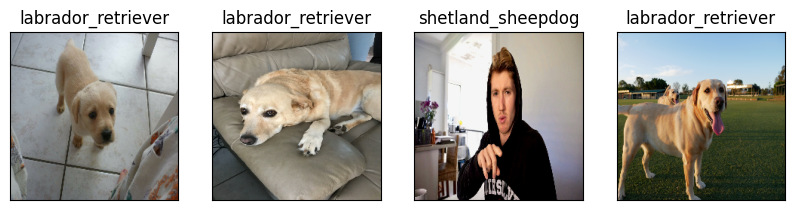

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)